<a href="https://colab.research.google.com/github/ipejun-ai/m5-accuracy/blob/master/evaluate_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

# custom imports
from multiprocessing import Pool        # Multiprocess Runs

warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
DIRPATH="/content/gdrive/My Drive/kaggle/m5-forecasting-accuracy/"
#DIRPATH="C:/Users/peiju/Documents/Study/kaggle/m5-forecasting-accuracy/"

In [0]:
val_binary="/output/m5-three-shades-of-dark-darker-magic_binary/validation_v22.csv"
val_pred="/output/m5-three-shades-of-dark-darker-magic//validation_v22.csv"

binary="/output/m5-three-shades-of-dark-darker-magic_binary/validation_v22.csv"
pred="/output/m5-three-shades-of-dark-darker-magic//validation_v22.csv"

In [0]:
val1=pd.read_csv(DIRPATH+val_binary)
val2=pd.read_csv(DIRPATH+val_pred)

sub1=pd.read_csv(DIRPATH+binary)
sub2=pd.read_csv(DIRPATH+pred)

In [0]:
all_preds=(val1>0.35)*val2
submission=(sub1>0.35)*sub2
submission.to_csv(DIRPATH+"/output/m5-three-shades-of-dark-darker-magic/submission_v23.csv")

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import gc

from sklearn import preprocessing
import lightgbm as lgb

from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm

In [0]:
class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, 
                 calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 'all'  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')]\
                     .columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')]\
                               .columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], 
                                 axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)\
                    [valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns]\
                    .set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index()\
                   .rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left',
                                    on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd'])\
                    .unstack(level=2)['value']\
                    .loc[zip(self.train_df.item_id, self.train_df.store_id), :]\
                    .reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns],
                               weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt) 

    def score(self, valid_preds: Union[pd.DataFrame, 
                                       np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape \
               == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, 
                                       columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], 
                                 valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):

            valid_preds_grp = valid_preds.groupby(group_id)[self.valid_target_columns].sum()
            setattr(self, f'lv{i + 1}_valid_preds', valid_preds_grp)
            
            lv_scores = self.rmsse(valid_preds_grp, i + 1)
            setattr(self, f'lv{i + 1}_scores', lv_scores)
            
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, 
                                  sort=False).prod(axis=1)
            
            all_scores.append(lv_scores.sum())
            
        self.all_scores = all_scores

        return np.mean(all_scores)

In [35]:
#reload data
d_dtypes = {}
for i in range(1914):
    d_dtypes[f'd_{i}'] = np.int32
sales = pd.read_csv(DIRPATH + 'sales_train_validation.csv',
                    dtype=d_dtypes)

# changing wide format to long format for model training
d = ['d_' + str(i) for i in range(1802,1914)]
sales_mlt = pd.melt(sales, id_vars=['item_id','dept_id','cat_id','store_id',
                                    'state_id'], value_vars=d)
sales_mlt = sales_mlt.rename(columns={'variable':'d', 'value':'sales'})

calendar = pd.read_csv(DIRPATH + 'calendar.csv',
                       dtype={'wm_yr_wk': np.int32, 'wday': np.int32, 
                              'month': np.int32, 'year': np.int32, 
                              'snap_CA': np.int32, 'snap_TX': np.int32,
                              'snap_WI': np.int32})

# subsetting calender by traning period
calendar = calendar.loc[calendar.d.apply(lambda x: int(x[2:])) \
                        >= int(sales_mlt.d[0][2:]), :]

prices = pd.read_csv(DIRPATH + 'sell_prices.csv',
                          dtype={'wm_yr_wk': np.int32, 
                                 'sell_price': np.float32})

train_df = sales.iloc[:, :-28]
valid_df = sales.iloc[:, -28:]

evaluator = WRMSSEEvaluator(train_df, valid_df, calendar, prices)

#sort

WRMSSEE = evaluator.score(all_preds.values)

In [0]:
def create_viz_df(df,lv):
    
    df = df.T.reset_index()
    if lv in [6,7,8,9,11,12]:
        df.columns = [i[0] + '_' + i[1] if i != ('index','') \
                      else i[0] for i in df.columns]
    df = df.merge(calendar.loc[:, ['d','date']], how='left', 
                  left_on='index', right_on='d')
    df['date'] = pd.to_datetime(df.date)
    df = df.set_index('date')
    df = df.drop(['index', 'd'], axis=1)
    
    return df

def create_dashboard(evaluator):
    
    wrmsses = [np.mean(evaluator.all_scores)] + evaluator.all_scores
    labels = ['Overall'] + [f'Level {i}' for i in range(1, 13)]

    ## WRMSSE by Level
    plt.figure(figsize=(12,5))
    ax = sns.barplot(x=labels, y=wrmsses)
    ax.set(xlabel='', ylabel='WRMSSE')
    plt.title('WRMSSE by Level', fontsize=20, fontweight='bold')
    for index, val in enumerate(wrmsses):
        ax.text(index*1, val+.01, round(val,4), color='black', 
                ha="center")
        
    # configuration array for the charts
    n_rows = [1, 1, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3]
    n_cols = [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
    width = [7, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
    height = [4, 3, 12, 3, 9, 9, 9, 9, 9, 9, 9, 9]
    
    for i in range(1,13):
        
        scores = getattr(evaluator, f'lv{i}_scores')
        weights = getattr(evaluator, f'lv{i}_weight')
        
        if i > 1 and i < 9:
            if i < 7:
                fig, axs = plt.subplots(1, 2, figsize=(12, 3))
            else:
                fig, axs = plt.subplots(2, 1, figsize=(12, 8))
                
            ## RMSSE plot
            scores.plot.bar(width=.8, ax=axs[0], color='g')
            axs[0].set_title(f"RMSSE", size=14)
            axs[0].set(xlabel='', ylabel='RMSSE')
            if i >= 4:
                axs[0].tick_params(labelsize=8)
            for index, val in enumerate(scores):
                axs[0].text(index*1, val+.01, round(val,4), color='black', 
                            ha="center", fontsize=10 if i == 2 else 8)
            
            ## Weight plot
            weights.plot.bar(width=.8, ax=axs[1])
            axs[1].set_title(f"Weight", size=14)
            axs[1].set(xlabel='', ylabel='Weight')
            if i >= 4:
                axs[1].tick_params(labelsize=8)
            for index, val in enumerate(weights):
                axs[1].text(index*1, val+.01, round(val,2), color='black', 
                            ha="center", fontsize=10 if i == 2 else 8)
                    
            fig.suptitle(f'Level {i}: {evaluator.group_ids[i-1]}', size=24 ,
                         y=1.1, fontweight='bold')
            plt.tight_layout()
            plt.show()

        trn = create_viz_df(getattr(evaluator, f'lv{i}_train_df')\
                            .iloc[:, -28*3:], i)
        val = create_viz_df(getattr(evaluator, f'lv{i}_valid_df'), i)
        pred = create_viz_df(getattr(evaluator, f'lv{i}_valid_preds'), i)

        n_cate = trn.shape[1] if i < 7 else 9

        fig, axs = plt.subplots(n_rows[i-1], n_cols[i-1], 
                                figsize=(width[i-1],height[i-1]))
        if i > 1:
            axs = axs.flatten()

        ## Time series plot
        for k in range(0, n_cate):

            ax = axs[k] if i > 1 else axs

            trn.iloc[:, k].plot(ax=ax, label='train')
            val.iloc[:, k].plot(ax=ax, label='valid')
            pred.iloc[:, k].plot(ax=ax, label='pred')
            ax.set_title(f"{trn.columns[k]}  RMSSE:{scores[k]:.4f}", size=14)
            ax.set(xlabel='', ylabel='sales')
            ax.tick_params(labelsize=8)
            ax.legend(loc='upper left', prop={'size': 10})

        if i == 1 or i >= 9:
            fig.suptitle(f'Level {i}: {evaluator.group_ids[i-1]}', size=24 , 
                         y=1.1, fontweight='bold')
        plt.tight_layout()
        plt.show()

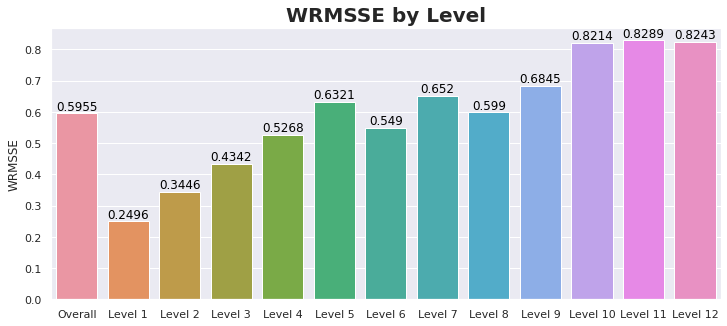

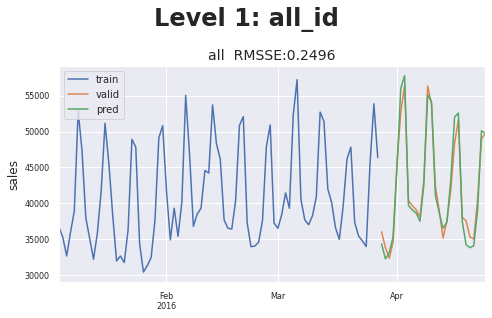

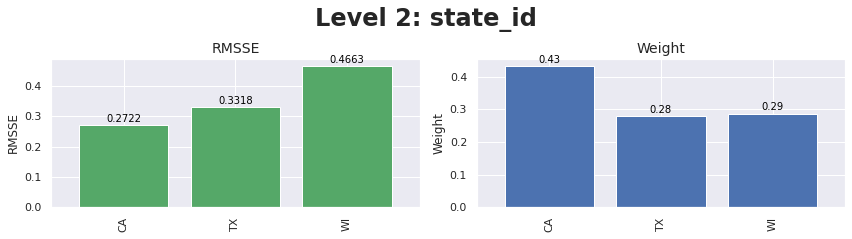

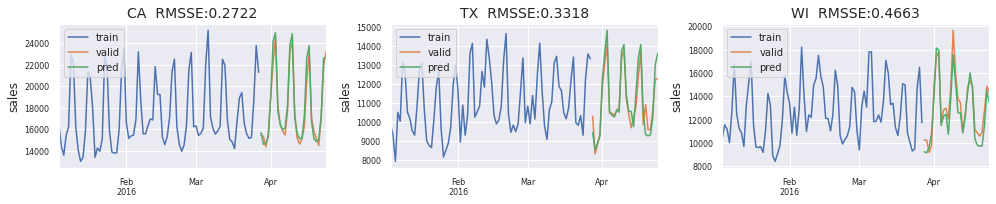

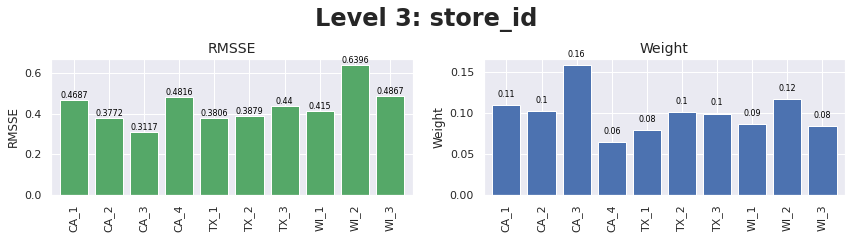

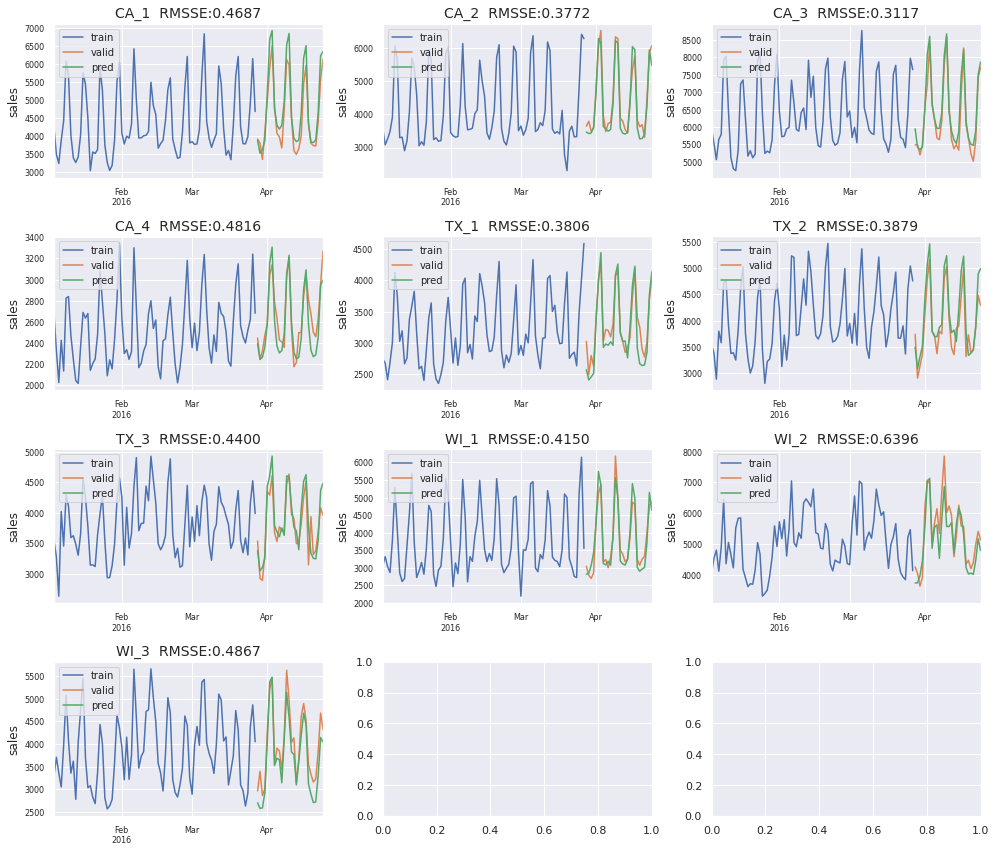

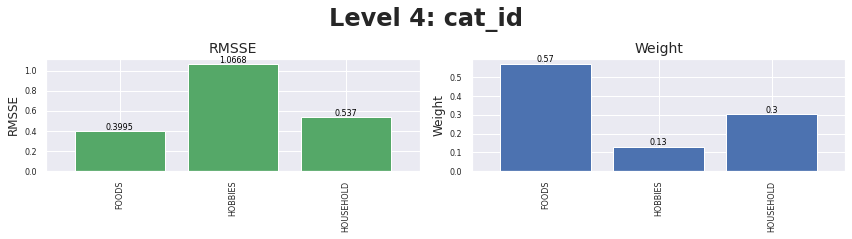

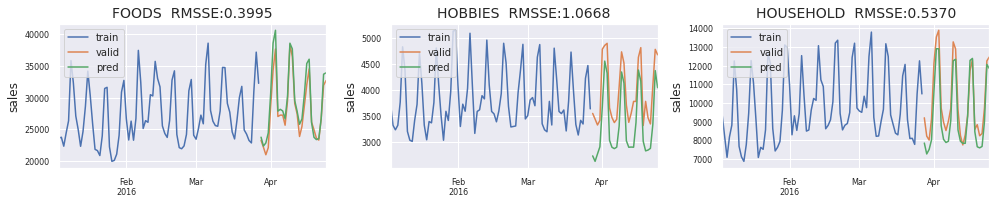

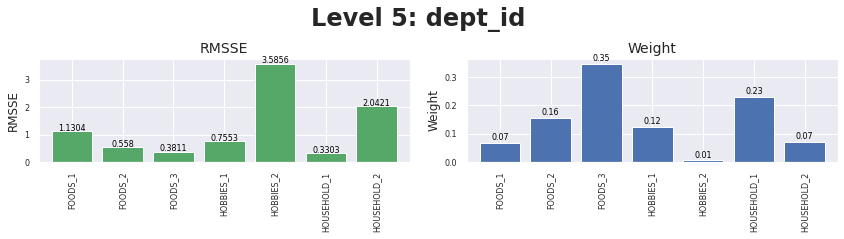

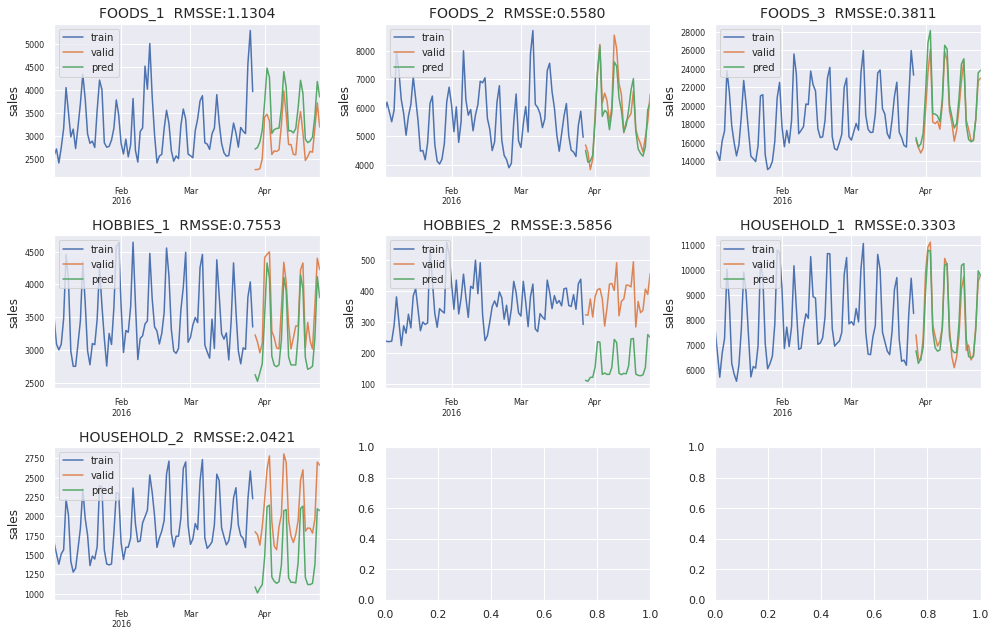

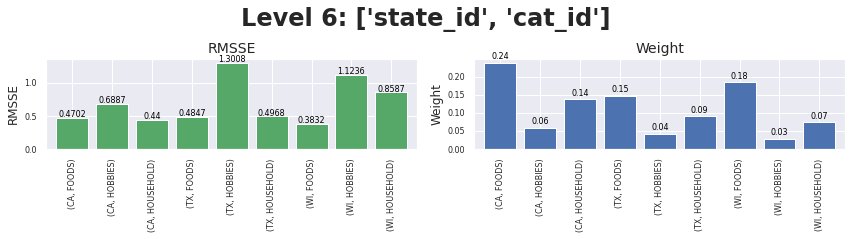

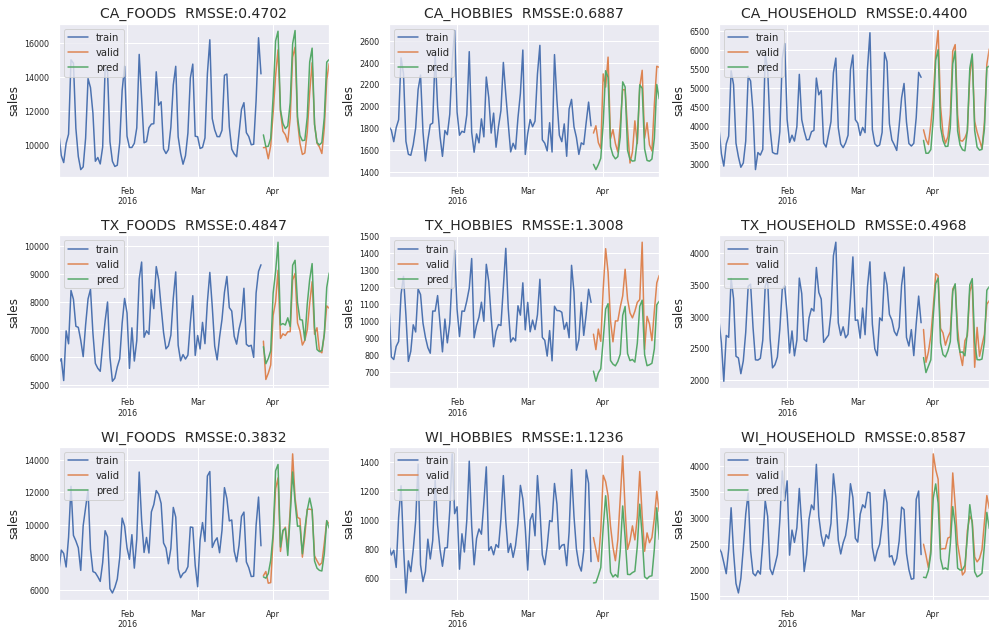

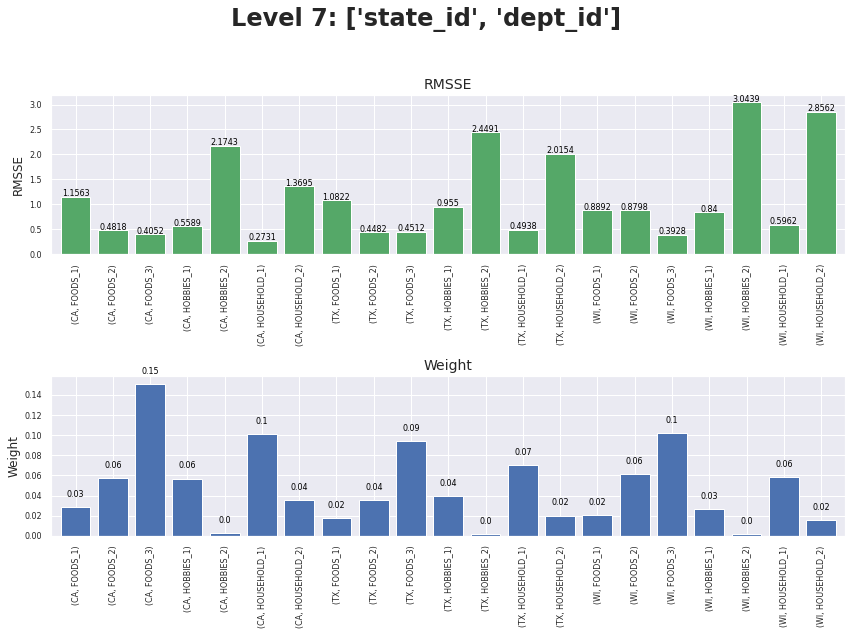

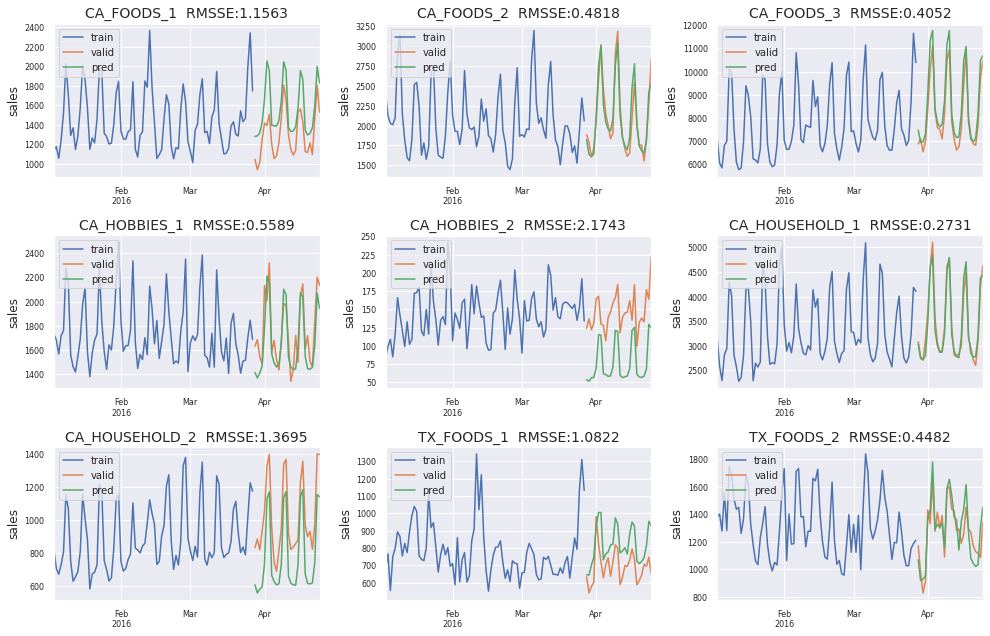

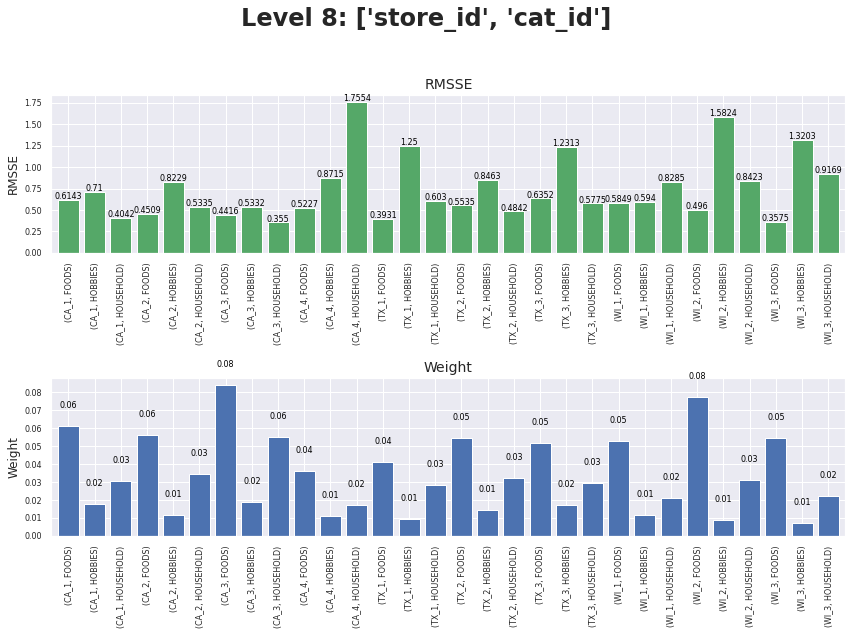

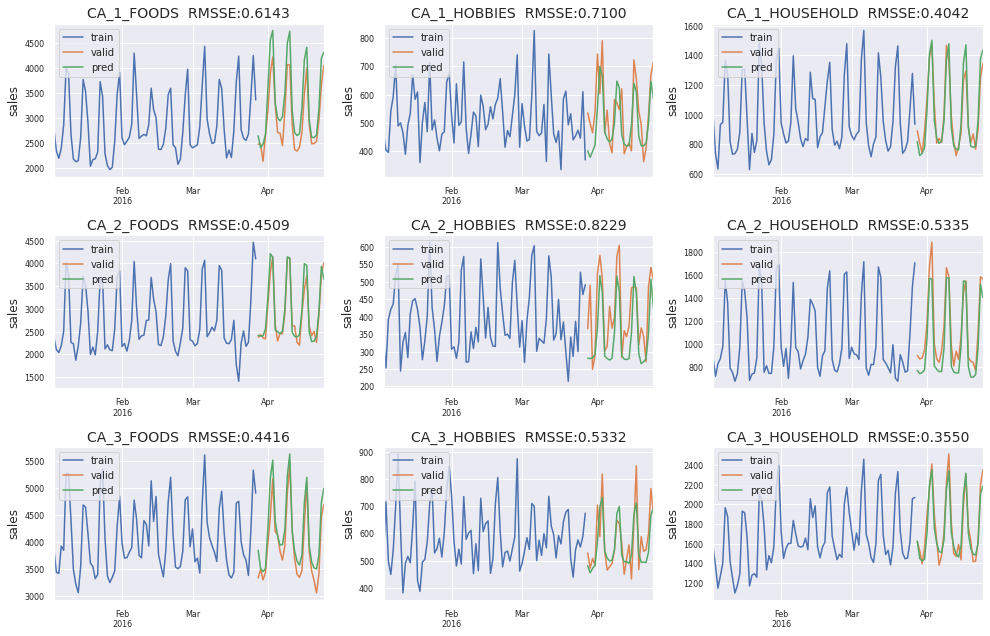

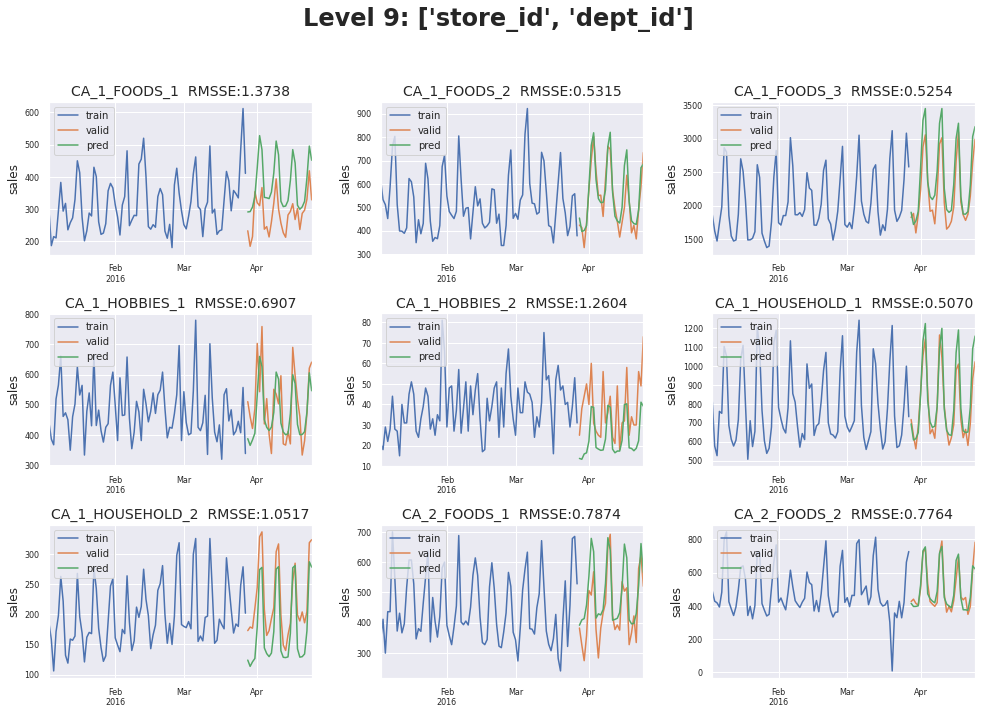

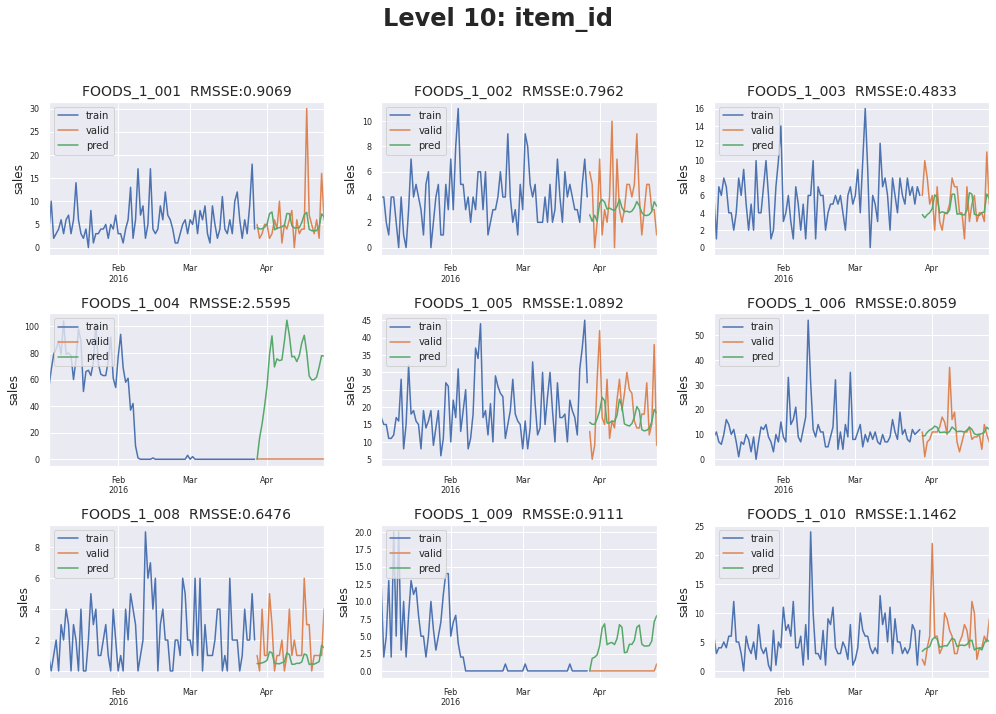

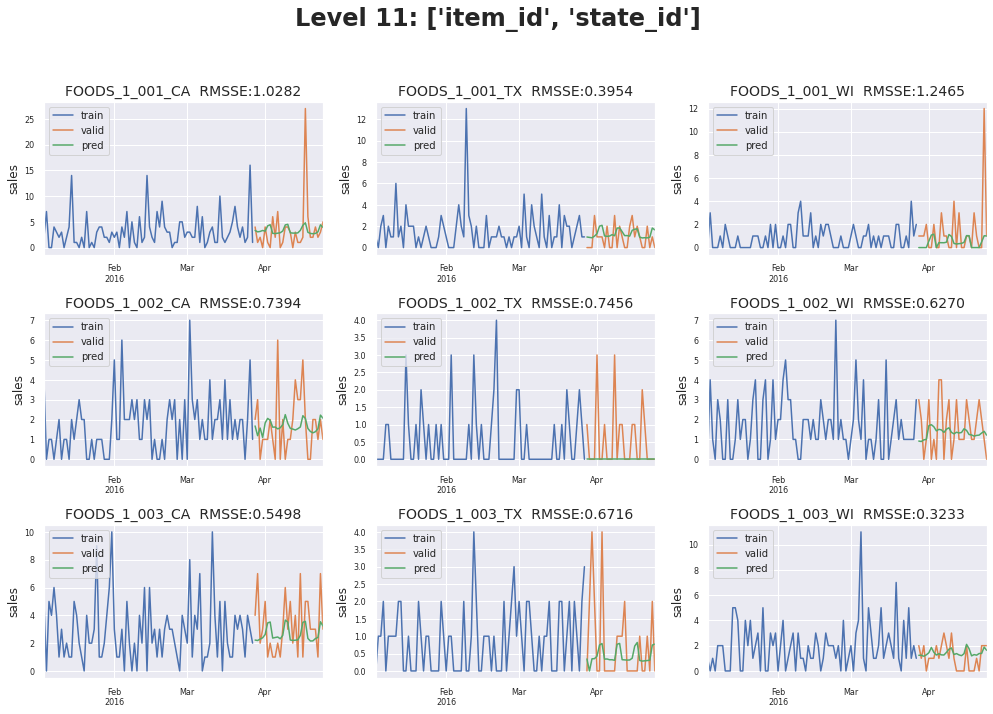

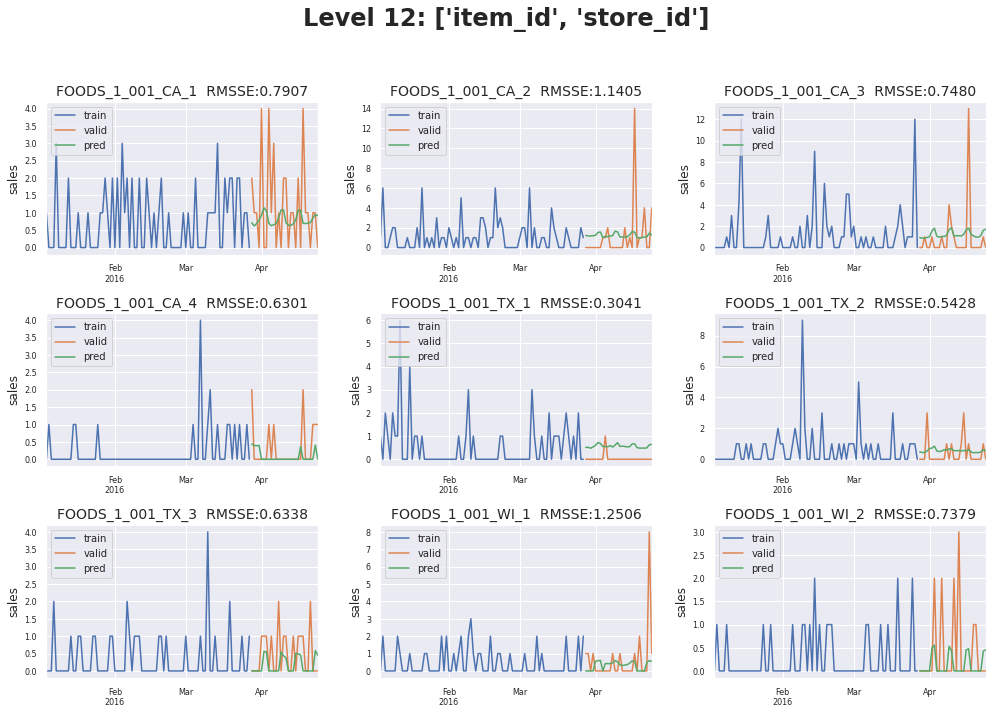

In [37]:
create_dashboard(evaluator)